In [ ]:
import os

from autogen_agentchat.agents import AssistantAgent
from autogen_agentchat.teams import RoundRobinGroupChat
from autogen_agentchat.ui import Console
from autogen_ext.models.openai import AzureOpenAIChatCompletionClient
from dotenv import load_dotenv

load_dotenv()

api_version = os.getenv("AZURE_OPENAI_API_VERSION")
api_key = os.getenv("AZURE_OPENAI_API_KEY")
azure_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
deployment_name = os.getenv("AZURE_OPENAI_DEPLOYMENT_NAME")
azure_openai_chat_completion_client = AzureOpenAIChatCompletionClient(
            model=deployment_name,
            azure_endpoint=azure_endpoint,
            api_version=api_version,
            api_key=api_key,
        )

# Define a tool
async def get_weather(city: str) -> str:
    return f"The weather in {city} is 73 degrees and Sunny."


async def main() -> None:
    # Define an agent
    weather_agent = AssistantAgent(
        name="weather_agent",
        model_client=azure_openai_chat_completion_client,
        tools=[get_weather],
    )

    # Define a team with a single agent and maximum auto-gen turns of 1.
    agent_team = RoundRobinGroupChat([weather_agent], max_turns=1)

    while True:
        # Get user input from the console.
        user_input = input("Enter a message (type 'exit' to leave): ")
        if user_input.strip().lower() == "exit":
            break
        # Run the team and stream messages to the console.
        stream = agent_team.run_stream(task=user_input)
        await Console(stream)


# NOTE: if running this inside a Python script you'll need to use asyncio.run(main()).
await main()

---------- TextMessage (user) ----------
서울날씨
---------- ToolCallRequestEvent (weather_agent) ----------
[FunctionCall(id='call_AXCW7iN6n4D21k7Shxkq5rdw', arguments='{"city":"서울"}', name='get_weather')]
---------- ToolCallExecutionEvent (weather_agent) ----------
[FunctionExecutionResult(content='The weather in 서울 is 73 degrees and Sunny.', name='get_weather', call_id='call_AXCW7iN6n4D21k7Shxkq5rdw', is_error=False)]
---------- ToolCallSummaryMessage (weather_agent) ----------
The weather in 서울 is 73 degrees and Sunny.
---------- TextMessage (user) ----------

---------- TextMessage (weather_agent) ----------
The current weather in Seoul is 73 degrees and sunny. If you need more information or have any other questions, feel free to ask!


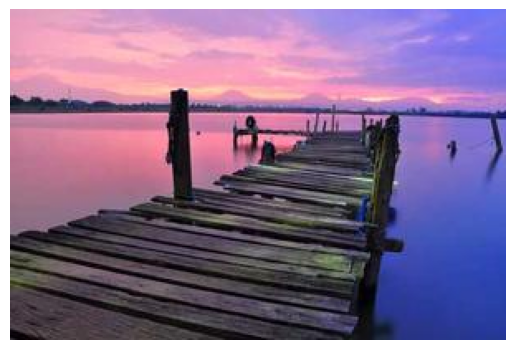

[]
source='assistant' models_usage=RequestUsage(prompt_tokens=283, completion_tokens=91) metadata={} created_at=datetime.datetime(2025, 6, 20, 7, 8, 18, 878892, tzinfo=datetime.timezone.utc) content='This image depicts a serene and picturesque scene of a wooden dock extending into calm water during sunset. The dock appears weathered and rustic, with vertical wooden posts scattered along its sides. The background features a stunning sky with vibrant hues of pink, purple, and blue, creating a tranquil atmosphere. The horizon is adorned with distant mountains or hills, silhouetted against the colorful sky. This image emanates a peaceful and calming vibe, characteristic of a scenic landscape.' type='TextMessage'


In [ ]:
from autogen_agentchat.messages import TextMessage

text_message = TextMessage(content="Hello, world!", source="User")

from io import BytesIO

import matplotlib.pyplot as plt
import requests
from autogen_agentchat.messages import MultiModalMessage
from autogen_core import CancellationToken
from autogen_core import Image as AGImage
from PIL import Image

pil_image = Image.open(BytesIO(requests.get("https://picsum.photos/300/200").content))
img = AGImage(pil_image)
multi_modal_message = MultiModalMessage(content=["Can you describe the content of this image?", img], source="User")
plt.imshow(pil_image) 
plt.axis('off') 
plt.show()

agent = AssistantAgent(
    name="assistant",
    model_client=azure_openai_chat_completion_client,
    system_message="Use tools to solve tasks.",
)

async def assistant_run() -> None:
    response = await agent.on_messages(
        [multi_modal_message],
        cancellation_token=CancellationToken(),
    )
    print(response.inner_messages)
    print(response.chat_message)



# Use asyncio.run(assistant_run()) when running in a script.
await assistant_run()

In [ ]:
from autogen_agentchat.agents import AssistantAgent
from autogen_agentchat.messages import TextMessage
from autogen_core import CancellationToken


# Define a tool that searches the web for information.
async def web_search(query: str) -> str:
    """Find information on the web"""
    return "AutoGen is a programming framework for building multi-agent applications."


# Create an agent that uses the OpenAI GPT-4o model.
model_client = azure_openai_chat_completion_client
agent = AssistantAgent(
    name="assistant",
    model_client=model_client,
    tools=[web_search],
    system_message="Use tools to solve tasks.",
)

async def assistant_run() -> None:
    response = await agent.on_messages(
        [TextMessage(content="Find information on AutoGen", source="user")],
        cancellation_token=CancellationToken(),
    )
    print(response.inner_messages)
    print(response.chat_message)


# Use asyncio.run(assistant_run()) when running in a script.
await assistant_run()

[ToolCallRequestEvent(source='assistant', models_usage=RequestUsage(prompt_tokens=61, completion_tokens=16), metadata={}, created_at=datetime.datetime(2025, 6, 20, 7, 8, 22, 20753, tzinfo=datetime.timezone.utc), content=[FunctionCall(id='call_PkSkrusZdx45F3MmFqWWQRF2', arguments='{"query":"AutoGen"}', name='web_search')], type='ToolCallRequestEvent'), ToolCallExecutionEvent(source='assistant', models_usage=None, metadata={}, created_at=datetime.datetime(2025, 6, 20, 7, 8, 22, 21227, tzinfo=datetime.timezone.utc), content=[FunctionExecutionResult(content='AutoGen is a programming framework for building multi-agent applications.', name='web_search', call_id='call_PkSkrusZdx45F3MmFqWWQRF2', is_error=False)], type='ToolCallExecutionEvent')]
source='assistant' models_usage=None metadata={} created_at=datetime.datetime(2025, 6, 20, 7, 8, 22, 21247, tzinfo=datetime.timezone.utc) content='AutoGen is a programming framework for building multi-agent applications.' type='ToolCallSummaryMessage' t

In [ ]:
from autogen_agentchat.agents import UserProxyAgent
from autogen_agentchat.messages import TextMessage
from autogen_core import CancellationToken


async def user_proxy_run() -> None:
    user_proxy_agent = UserProxyAgent("user_proxy")
    response = await user_proxy_agent.on_messages(
        [TextMessage(content="What is your name? ", source="user")], cancellation_token=CancellationToken()
    )
    print(f"Your name is {response.chat_message.content}")


# Use asyncio.run(user_proxy_run()) when running in a script.
await user_proxy_run()

Your name is hello


In [ ]:
from autogen_agentchat.ui import Console


async def assistant_run_stream() -> None:
    # Option 1: read each message from the stream (as shown in the previous example).
    # async for message in agent.on_messages_stream(
    #     [TextMessage(content="Find information on AutoGen", source="user")],
    #     cancellation_token=CancellationToken(),
    # ):
    #     print(message)

    # Option 2: use Console to print all messages as they appear.
    await Console(
        agent.on_messages_stream(
            [TextMessage(content="Find information on AutoGen", source="user")],
            cancellation_token=CancellationToken(),
        )
    )


# Use asyncio.run(assistant_run_stream()) when running in a script.
await assistant_run_stream()

---------- ToolCallRequestEvent (assistant) ----------
[FunctionCall(id='call_cV7hmD42qJsml9f1wneyWnVr', arguments='{"query":"AutoGen framework multi-agent applications"}', name='web_search')]
---------- ToolCallExecutionEvent (assistant) ----------
[FunctionExecutionResult(content='AutoGen is a programming framework for building multi-agent applications.', name='web_search', call_id='call_cV7hmD42qJsml9f1wneyWnVr', is_error=False)]
---------- assistant ----------
AutoGen is a programming framework for building multi-agent applications.
